## __08_08 문서 유사도__

---
### 코사인 유사도
__코사인 유사도(Cosine Similarity)__: <br>벡터의 상호 방향성이 얼마나 유사한지 기반, 사잇각을 구해 수치로 적용한다.
<br><br>
### 두 벡터 사잇각
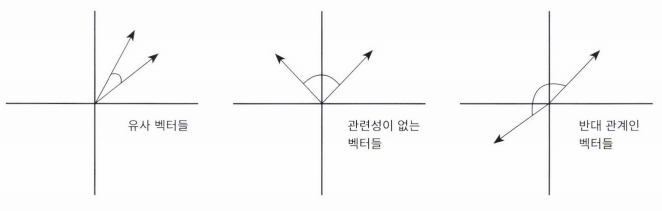

문서를 피처 벡터화 변환하면 차원이 매우 많은 희소 행렬이 되기 쉽고, <br> 희소 행렬 기반에서 문서 벡터간의 크기에 기반한 유사도 지표는 정확도가 떨어지기 쉬워<br> 빈도수에만 기반해서 공정한 비교를 할 수 없다.

##### 서로간의 문서 유사도를 코사인 유사도 기반으로 구해봅니다

In [1]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product=np.dot(v1, v2)
    l2_norm=(np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity=dot_product/l2_norm
    
    return similarity

##### doc_list로 정의된 3개의 간단한 문서의 유사도를 비교하기 위해 __문서를 TF-IDF로 벡터화된 행렬로 변환__

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list=['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple=TfidfVectorizer()
feature_vect_simple=tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape) 

(3, 18)


##### 반환된 행렬은 희소행렬이므로 cos_similarity의 인자인 array로 만들기 위해 밀집 행렬로 변환 > 배열로 변환

In [5]:
# TfidfVectorizer로 transform한 형태는 희소 행렬 > 밀집 행렬로 변환
feature_vect_dense=feature_vect_simple.todense()

# 첫번째 문장, 두번째 문장의 피처 벡터 추출
vect1=np.array(feature_vect_dense[0]).reshape(-1,)
vect2=np.array(feature_vect_dense[1]).reshape(-1,)

# 첫번째 문장과 두번째 문장의 피처 벡터로 두 개 문장의 코사인 유사도 추출
similarity_simple=cos_similarity(vect1, vect2)
print('문장1, 문장2 코사인 유사도: {0:.3f}'.format(similarity_simple)) 

문장1, 문장2 코사인 유사도: 0.402


##### 1, 2 문장의 유사도 0.402 > 1,3 문장 & 2,3 문장 유사도 측정

In [6]:
vect3=np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple=cos_similarity(vect1, vect3)
print('문장1, 문장3 코사인 유사도: {0:.3f}'.format(similarity_simple))

similarity_simple=cos_similarity(vect2, vect3)
print('문장2, 문장3 코사인 유사도: {0:.3f}'.format(similarity_simple)) 

문장1, 문장3 코사인 유사도: 0.404
문장2, 문장3 코사인 유사도: 0.456


##### 사이킷런의 sklearn.metrics.pairwise.cosine_similarity를 이용해 코사인 유사도 측정 가능 
- 첫번째 입력 파라미터: 비교 기준이 되는 문서의 피처 행렬
- 두번째 입력 파라미터: 비교되는 문서의 피처 행렬
<br><br>
희소 행렬, 밀집 행렬 모두가 가능하며 행렬, 배열도 가능하다. 별도의 변환 작업 필요 XXXX

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair=cosine_similarity(feature_vect_simple[0], feature_vect_simple)
print(similarity_simple_pair) 

[[1.         0.40207758 0.40425045]]


In [8]:
# feature_vect_simple[1:]를 적용해 본인 제외한 유사도만 측정
similarity_simple_pair=cosine_similarity(feature_vect_simple[0], feature_vect_simple[1:])
print(similarity_simple_pair) 

[[0.40207758 0.40425045]]


##### 쌍으로 코사인 유사도 값을 제공할 수 있음 <br><br> 1과 2, 3 & 2와 1, 3 & 3과 1, 2 문서의 코사인 유사도를 ndarray 형태로  제공

In [9]:
similarity_simple_pair=cosine_similarity(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)
print('shape:', similarity_simple_pair.shape) 

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


---
### Opinion Review 데이터 이용한 문서 유사도 측정

In [10]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict))) 

In [13]:
import pandas as pd
import glob ,os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

path = r'C:\Users\82109\Desktop\20-1.5 쿠글\OpinosisDataset1.0\topics'
all_files = glob.glob(os.path.join(path, "*.data"))     
filename_list = []
opinion_text = []

for file_ in all_files:
    df = pd.read_table(file_,index_col=None, header=0,encoding='latin1')
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english' , \
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

C:\Users\82109\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


##### 호텔을 주제로 군집화된 문서를 이용해 문서간 유사도 측정 <br><br>
##### DF의 document_df 에서 호텔로 군집화된 문서 인덱스 추출<br> TF-IDF의 feature_vect에서 호텔로 군집화된 문서의 피처 벡터 추출

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=1인 데이터는 호텔로 클러스터링된 데이터임. DataFrame에서 해당 Index를 추출
hotel_indexes = document_df[document_df['cluster_label']==1].index
print('호텔로 클러스터링 된 문서들의 DataFrame Index:', hotel_indexes)

# 호텔로 클러스터링된 데이터 중 첫번째 문서를 추출하여 파일명 표시.  
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('\n##### 비교 기준 문서명 ',comparison_docname,' 와 타 문서 유사도######')

''' document_df에서 추출한 Index 객체를 feature_vect로 입력하여 호텔 클러스터링된 feature_vect 추출 
이를 이용하여 호텔로 클러스터링된 문서 중 첫번째 문서와 다른 문서간의 코사인 유사도 측정.'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]] , feature_vect[hotel_indexes])
print(similarity_pair) 

호텔로 클러스터링 된 문서들의 DataFrame Index: Int64Index([1, 13, 14, 15, 20, 21, 24, 28, 30, 31, 32, 38, 39, 40, 45, 46], dtype='int64')

##### 비교 기준 문서명  bathroom_bestwestern_hotel_sfo  와 타 문서 유사도######
[[1.         0.0430688  0.05221059 0.06189595 0.05846178 0.06193118
  0.03638665 0.11742762 0.38038865 0.32619948 0.51442299 0.11282857
  0.13989623 0.1386783  0.09518068 0.07049362]]


##### 문서간 유사도가 높은 순으로 정렬하고 시각화

Text(0.5, 1.0, 'bathroom_bestwestern_hotel_sfo')

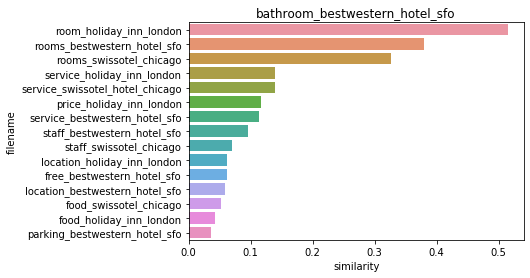

In [19]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 첫번째 문서와 타 문서간 유사도가 큰 순으로 정렬한 인덱스를 추출하되, 자신은 제외함
sorted_index=similarity_pair.argsort()[:, ::-1]
sorted_index=sorted_index[:, 1:]

# 유사도가 큰 순으로 hotel_indexes를 추출해 재정렬
hotel_sorted_indexes=hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도값을 재정렬하되, 자기 자신은 제외
hotel_1_sim_value=np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value=hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 인덱스와 유사도 값을 이용해 파일명, 유사도 값을 막대그래프로 시각화
hotel_1_sim_df=pd.DataFrame()
hotel_1_sim_df['filename']=document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity']=hotel_1_sim_value

sns.barplot(x='similarity', y='filename', data=hotel_1_sim_df)
plt.title(comparison_docname) 

##### 첫번째 문서 베스트 웨스턴 호텔 화장실 리뷰와 가장 비슷한 문서:  room_holidaty_inn_london 

---
## __08_09 한글 텍스트 처리 - 네이버 영화 평점 감성 분석__


---
### 한글 NLP 처리의 어려움
__한글은 띄어쓰기, 조사 때문에 처리가 어려움__ <br> > 조사의 수가 매우 많아 어근 추출 등의 전처리가 어려움

---
### KoNLPy 
파이썬의 대표적인 한글 형태소 패키지 <br>
꼬꼬마(Kkma), 한나눔(Hannanum), Komoran, 은전한닢 프로젝트(Mecab), Okt(전 Twitter)의 5개 분석모듈 사용 가능<br><br>
- __형태소__: 단어로서 의미를 가지는 최소 단위 <br>
- __형태소 분석(Morphological analysis)__: 말뭉치를 형태소 어근 단위로 쪼개고 각 형태소에 품사 태깅(POS tagging)을 부착하는 작업을 지칭

In [20]:
pip install konlpy

  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.8.2
    Uninstalling beautifulsoup4-4.8.2:
      Successfully uninstalled beautifulsoup4-4.8.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
from konlpy.tag import Komoran

komoran=Komoran()
print(komoran.nouns('나에겐 너무 어려운 공부~')) 

['공부']


---
### 데이터 로딩 - 네이버 영화 평점
<br><br>
https://github.com/e9t/nsmc

In [1]:
import pandas as pd

train_df=pd.read_csv('ratings_train.txt', sep='\t')
train_df.head() 

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
train_df['label'].value_counts() # 1 긍정 0 부정

0    75173
1    74827
Name: label, dtype: int64

##### 0과 1이 어느 한쪽으로 치우치지 않고 균등한 분포를 나타냄<br><br>
##### document 칼럼에 Null이 존재하기 때문에 공백으로 변환

In [3]:
import re

train_df=train_df.fillna(' ')
# 정규 표현식을 이용해 숫자를 공백으로 변경(정규 표현식으로 \d : 숫자)
train_df['document']=train_df['document'].apply(lambda x : re.sub(r"\d+", " ", x))

# 테스트 데이터 세트를 로딩하고 Null, 숫자를 공백으로 변환
test_df=pd.read_csv('ratings_test.txt', sep='\t')
test_df=test_df.fillna(' ')
test_df['document']=test_df['document'].apply(lambda x : re.sub(r"\d+", " ", x)) 

##### TF-IDF 방식으로 단어 벡터화  > 한글 형태소 분석 이용, 형태소 단어로 토근화<br><br> SNS 분석에 적합한 Twitter 클래스 이용 > morphs( ) 문장을 형태소 단어 형태로 토큰화해 list 반환

In [4]:
from konlpy.tag import Okt

okt=Okt()
def tw_tokenizer(text):
    # 입력 인자로 들어온 텍스트를 형태소 단어로 토큰화해 리스트 형태로 반환
    tokens_ko=okt.morphs(text)
    return tokens_ko

##### 사이킷런의 TfidifVectorizer 를 이용해 TF-IDF 피처 모델 생성 , 위의 tw_tokenizer 함수 이용 

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Twitter 객체의 morphs( ) 객체를 이용한 tokenizer를 사용. ngram_range는 (1,2) 
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document']) 

C:\Users\82109\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


##### 로지스틱 회귀를 이용해 분류 기반의 감성 분석 수행 <br><br> 로지스틱 회귀의 C를 최적화하기 위해 GridSearchCV 이용

In [6]:
lg_clf=LogisticRegression(random_state=0)

# 파라미터 C를 최적화하기 위해 GridSearchCV 이용
params={'C':[1,3.5,4.5,5.5,10]}
grid_cv=GridSearchCV(lg_clf, param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_cv.fit(tfidf_matrix_train, train_df['label'])
print(grid_cv.best_params_, round(grid_cv.best_score_, 4)) 

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\82109\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\82109\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver op

{'C': 3.5} 0.8592


C:\Users\82109\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


##### C가 3.5일때 최고  0.8592의 정확도<br><br>
##### 최종 감성 분석 예측 > 앞서 사용한 tfidf 그대로 사용

In [7]:
from sklearn.metrics import accuracy_score

# 학습 데이터를 적용한 TfidfVectorizer를 이용해 테스트 데이터를 TF-IDF 값으로 피처 변환
tfidf_matrix_test=tfidf_vect.transform(test_df['document'])

# 분류기는 GridSearchCV에서 최적 하이퍼 파라미터로 학습된 것 이용
best_estimator=grid_cv.best_estimator_
preds=best_estimator.predict(tfidf_matrix_test)

print('Logistic Regression 정확도: ', accuracy_score(test_df['label'], preds)) 

Logistic Regression 정확도:  0.86186


## __08_10 텍스트 분석 실습 <br> - 캐글 Mercari Price Suggestion Challenge__
<br><br>
https://www.kaggle.com/c/mercari-price-suggestion-challenge/data

__변수 설명__
- train_id: 데이터 id
- name: 제품명
- item_condition_id: 판매자가 제공하는 제품 상태
- category_name: 카테고리명
- brand_name: 브랜드명
- price: 제품 가격, 예측을 위한 타깃 속성
- shipping: 배송비 무료 여부 > 1 무료, 0 유료
- item_discription: 제품에 대한 설명
---
우리가 예측할 변수는 __price__ 회귀로 피처를 학습한 뒤 price를 예측한다<br>
기존과 다르게 item_discription 같은 텍스트 형태의 비정형 데이터 & 정형 속성을 같이 적용해 회귀 수행

### 데이터 전처리

In [8]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df=pd.read_csv('mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head() 

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


##### Null 여부 확인

In [9]:
print(mercari_df.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


##### brand_name이 많은 Null을 가지고 있음. 전체 1482535개 중 849853개만 not null <br><br> 
##### price 칼럼의 데이터 분포도 확인

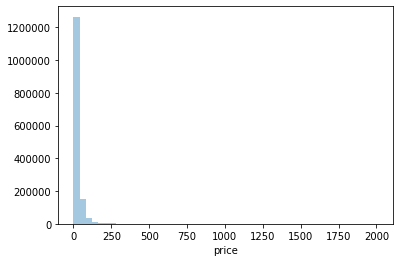

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df=mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df, kde=False) 

##### 비교적 가격이 적은 쪽에 왜곡된 분포도를 가짐 > 로그 변환

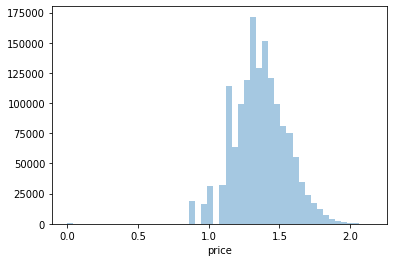

In [12]:
import numpy as np

y_train_df=np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False) 

##### 로그변환해서 정규분포에 가까워짐 > DF의 price를 로그변환 값으로 변경

In [13]:
mercari_df['price']=np.log1p(mercari_df['price'])
mercari_df['price'].head() 

0    2.397895
1    3.970292
2    2.397895
3    3.583519
4    3.806662
Name: price, dtype: float64

##### Shipping, item_condition 값의 유형 확인

In [15]:
print('Shipping 값 유형: \n', mercari_df['shipping'].value_counts())
print('\nitem_condition 값 유형: \n', mercari_df['item_condition_id'].value_counts()) 

Shipping 값 유형: 
 0    819435
1    663100
Name: shipping, dtype: int64

item_condition 값 유형: 
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


##### 배송미 유무인 Shipping의 분포는 비교적 균일, item_condition은 1,2,3이 주를 이룸<br><br>
##### item_discription 칼럼의 'No description_yet' 값이 얼마나 있는지 확인

In [16]:
boolean_cond=mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count() 

82489

##### category_name 확인 /로 분리된 문자열 <br><br> /를 기준으로 단어 토큰화하고 각각 별도의 피처로 저장 > 알고리즘 학습<br>
---
##### split_cat( ) 함수를 생성해 /기준으로 단어를 나눔
- Null이 아닌 경우에 split('/')를 이용해 대, 중, 소 분류
- Null인 경우에 split() 에러 발생 > 에러를 except catch해 대, 중, 소 분류 모두 Other Null 값 부여
- 대, 중, 소 칼럼은 mercari_df 에서 cat_dae, cat_jung, cat_so 로 부여

In [19]:
# apply lambda 에서 호출되는 대, 중, 소 분할 함수 생성 > 리스트로 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other Null', 'Other Null', 'Other Null']
    
    
# 위의 split_cat을  apply lambda에서 호출해 대, 중, 소 칼럼을 marcari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so']= zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류 소분류는 값의 유형이 많으니까 분류 개수만 추출
print('대분류 유형:\n', mercari_df['cat_dae'].value_counts(), '\n')
print('중분류 개수: ', mercari_df['cat_jung'].nunique(), '\n')
print('소분류 개수: ', mercari_df['cat_so'].nunique(), '\n') 

대분류 유형:
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other Null                  6327
Name: cat_dae, dtype: int64 

중분류 개수:  114 

소분류 개수:  871 



##### 대분류의 경우 Women, Beauty 등 분류가 많음 , 중분류 114개, 소분류 817개로 구성<br><br>
##### brand_name, category_name, item_description 의 Null을 모두 Other Null로 변경

In [20]:
mercari_df['brand_name']=mercari_df['brand_name'].fillna(value='Other Null')
mercari_df['category_name']=mercari_df['category_name'].fillna(value='Other Null')
mercari_df['item_description']=mercari_df['item_description'].fillna(value='Other Null')

# 각 칼럼별로 Null 값 건수 확인
mercari_df.isnull().sum() 

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

---
### 피처 인코딩 & 피처 벡터화

##### brand name & name 확인

In [24]:
print('brand name의 유형 건수: \n', mercari_df['brand_name'].nunique())
print('\nbrand name sample 5건: \n', mercari_df['brand_name'].value_counts()[:5]) 

brand name의 유형 건수: 
 4810

brand name sample 5건: 
 Other Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


In [25]:
print('name의 종류 개수: \n', mercari_df['name'].nunique())
print('\nname sample 10건: \n', mercari_df['name'][:10]) 

name의 종류 개수: 
 1225273

name sample 10건: 
 0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


In [26]:
pd.set_option('max_colwidth', 200)

# item_description 의 평균 문자열 크기
print('item_description 의 평균 문자열 크기: \n', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2] 

item_description 의 평균 문자열 크기: 
 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

#####  name : count기반 피처 벡터화 변환<br> item_description : TF-IDF 변환

In [27]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec=CountVectorizer()
X_name=cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp=TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp=tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape: \n', X_name.shape)
print('\nitem_description vectorization shape: \n', X_descp.shape)

name vectorization shape: 
 (1482535, 105757)

item_description vectorization shape: 
 (1482535, 50000)


##### cat_dae, cat_jung, cat_so, brand_name, shipping, item_condition 모두 X_name, X_descp와 결합돼 ML 모델 실행의 기반 데이터 세트로 재구성 
---
##### 희소 행렬 형태로 인코딩을 적용한 뒤 함께 결합
- LabelBinarizer를 이용, 희소 행렬 형태의 원-핫 인코딩
- sparse 모듈의 hstack() 함수를 이용해 개별 칼럼 결합

In [28]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so']) 

##### 제대로 변환됐는지 확인

In [29]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape)) 

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


##### 피처 벡터화한 데이터 세트 & 희소 인토딩 변환한 데이터 세트를 hstack을 이용해 모두 결합

In [30]:
from  scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합. 
X_features_sparse= hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제. 
del X_features_sparse
gc.collect() 

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


60

##### 결합 데이터가 많은 메모리를 차지 > gc.collect( )로 결합 데이터 삭제

---
### 릿지 회귀 모델 구축 & 평가
1. 모델을 평가하는 평가 로직 함수화<br><br>
2. RMSLE 방식으로 평가
    - RMSLE 구하는 함수 rmsle((y, y_pred))로 생성 
    - price값이 로그 변환 되어 있으니까 다시 원복해서 RMSLE 적용하도록<br> evaluate_org_price(y_test, preds) 함수 생성

In [31]:
def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds): 
    
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요. 
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

##### 학습용 데이터 생성, 모델을 학습/예측하는 로직을 별도의 함수로 생성
해당 함수는 여러 희소 행렬을 hstack()으로 결합한 뒤 학습과 테스트 데이터 세트로 분할 후 모델 학습 및 예측을 수행 

In [32]:
import gc 
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], 
                                                      test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    
    del X , X_train , X_test , y_train 
    gc.collect()
    
    return preds , y_test

##### 릿지 회귀로 price 예측 수행 & item_description 같은 텍스트 속성이 얼마나 영향을 미치는지 확인

In [33]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds)) 

Item Description을 제외했을 때 rmsle 값: 0.5013207260753978
Item Description을 포함한 rmsle 값: 0.4712229546241491


In [34]:
import gc
gc.collect() 

20

---
### LGBM 회귀 모델 구축 & 앙상블을 이용한 최종 예측 평가
1. LGBM으로 회귀 수행<br><br>
2. 릿지, LGBM을 간단한 앙상블 방식으로 섞어서 최종 회귀 예측값 평가

##### LGBM

In [35]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds)) 

LightGBM rmsle 값: 0.4574723025630168


##### 릿지&LGBM 앙상블해 최종 예측 결괏값 도출 > 릿지*0.55 , LGBM*0.45

In [36]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds)) 

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.450764592862551
